<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Transmissão-10G-OOK-apenas-com-dispersão-e-perda" data-toc-modified-id="Transmissão-10G-OOK-apenas-com-dispersão-e-perda-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transmissão 10G OOK apenas com dispersão e perda</a></span></li></ul></div>

In [1]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
import numpy as np
import scipy.special as sp
from  scipy.constants import c
import matplotlib.pyplot as plt
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from commpy.utilities  import signal_power, upsample
from utils.models import mzm

In [3]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Transmissão 10G OOK apenas com dispersão e perda

In [41]:
# parâmetros da simulação
SpS = 32

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

lmbd   = 1550e-9       # comprimento de onda

Pi_dBm = 0             # potência de sinal óptico na entrada do modulador em dBm

# Parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# Parâmetros da fibra
D = 18e-6                        # Parâmetro de dispersão ps/(nm*km) - SMF28
beta2 = -(D*lmbd**2)/(2*np.pi*c) # GVD
z = 70e3                         # Comprimento do enlace
alphadB = 0.16                   # dB/Km
alpha   = 1e-3*alphadB/4.343     # 1/m

# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W

In [42]:
LD = (Ts**2)/abs(beta2)
print('Comprimento de dispersão [m]: %f' %(LD))
LP = 1e-3*1/alpha
print('Comprimento efetivo de perdas [km]: %f' %(LP))

Comprimento de dispersão [m]: 435576.729636
Comprimento efetivo de perdas [km]: 27.143750


In [43]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# plota sinal 
t = np.arange(0, symbTx.size)*(Ta/1e-9)

#idX = np.arange(0,513)
idX = np.arange(0,1023)

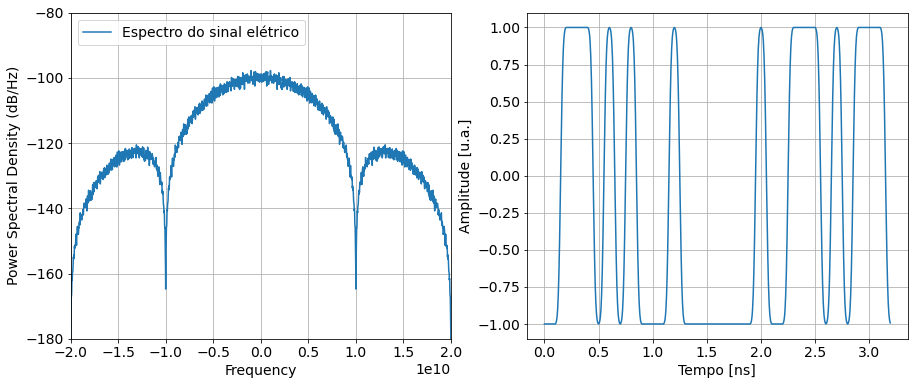

In [44]:
# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

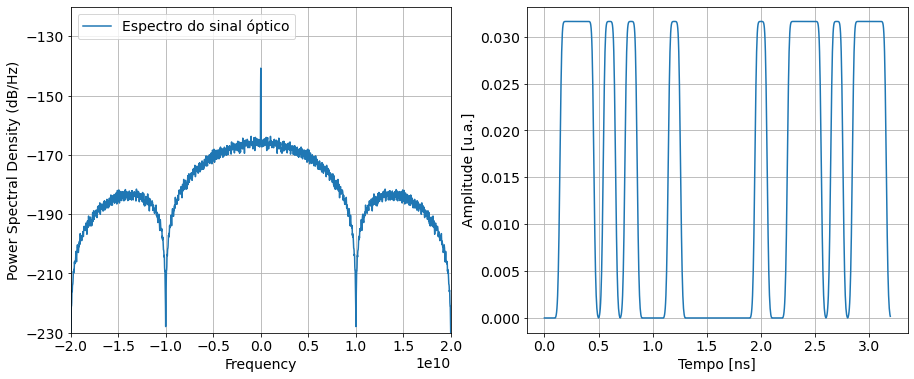

In [45]:
# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, sigTx, Vb)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-230,-120);
axs[0].psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], np.abs(sigTxo[idX]))
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

In [46]:
# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

# Fibra óptica
H  = np.exp(1j*0.5*beta2*z*(2*np.pi*freq)**2)*np.exp(-0.5*alpha*z) # Função de transferência do canal
sigRxoFFT = H * sigTxoFFT
sigRxoPx  = np.abs(sigRxoFFT)**2
sigRxo = np.fft.ifft(sigRxoFFT)*NFFT

Potência do sinal Tx (em dBm) = -3.02 dBm
Potência do sinal Rx (em dBm) = -14.22 dBm


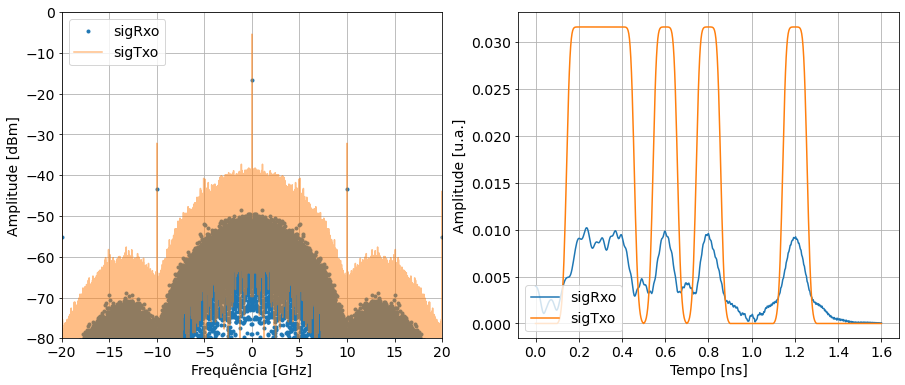

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-80,0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[0:513], abs(sigRxo[0:513]), label = 'sigRxo')
axs[1].plot(t[0:513], abs(sigTxo[0:513]), label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal Tx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))
print('Potência do sinal Rx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigRxoPx)/1e-3)))

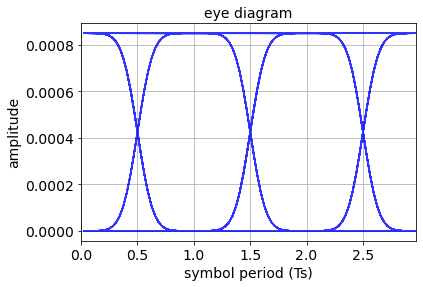

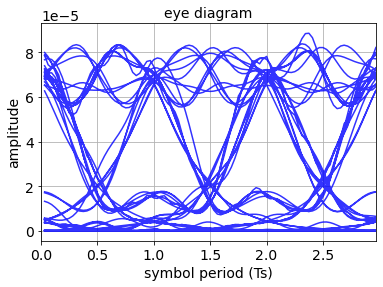

In [48]:
# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxo)**2

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS)
eyediagram(I_Rx, Nsamples, SpS)